In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import multiprocess      as mp
import pandas            as pd

from libraries                         import utils
from pymatgen.analysis.phase_diagram   import PhaseDiagram
from pymatgen.entries.computed_entries import ComputedEntry
from os                                import path
from sklearn                           import model_selection
from sklearn.ensemble                  import RandomForestRegressor
from sklearn.neural_network            import MLPRegressor
from sklearn.model_selection           import ShuffleSplit

sns.set_theme()

Defining general output properties

In [2]:
linewidth      = 0.5
footnotesize   = 8
s_footnotesize = 10*0.8
eps_dpi        = 100
png_dpi        = 400
output_folder  = 'output/ternary_chalcohalides'
input_folder   = 'input/ternary_chalcohalides'

# Iterations might be run from here

In [54]:
miller_index = '011'

In [55]:
vbm     = np.loadtxt(f'{input_folder}/results_vbm_{miller_index}.txt')
bandgap = np.loadtxt(f'{input_folder}/results_band_gap.txt')

In [56]:
# Convert the array to a Pandas DataFrame
vbmd = pd.DataFrame(vbm, columns=["x", "y", "z", "vbm"])
vbmd.set_index(["x", "y", "z"], inplace=True)

bandgapd = pd.DataFrame(bandgap, columns=["x", "y", "z", "bandgap"])
bandgapd.set_index(["x", "y", "z"], inplace=True)

# Combine the DataFrames, aligning by index
data = pd.concat([vbmd, bandgapd], axis=1)

data['cbm'] = data['vbm'] + data['bandgap']
data

vbm   bandgap       cbm
x   y   z                                 
0.0 0.0 0.00 -6.254893  1.524687 -4.730207
        0.05 -6.267216  1.529355 -4.737860
        0.10 -6.279674  1.532872 -4.746801
        0.15 -6.292131  1.536684 -4.755447
        0.20 -6.303879  1.542081 -4.761798
...                ...       ...       ...
1.0 1.0 0.80 -6.729563  1.596269 -5.133294
        0.85 -6.706043  1.575322 -5.130720
        0.90 -6.683013  1.553251 -5.129762
        0.95 -6.658384  1.529336 -5.129048
        1.00 -6.632612  1.505291 -5.127321

[1819 rows x 3 columns]

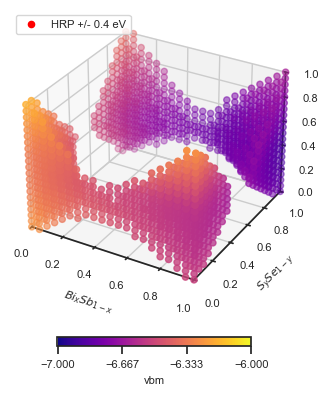

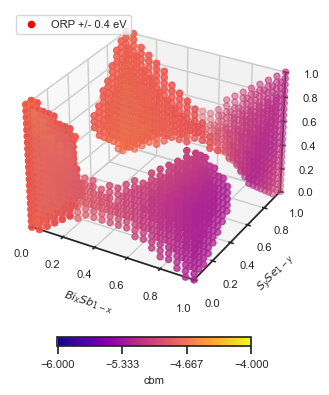

In [59]:
valid_xyz = np.array(data.index.to_frame(index=False).values)
for target in ['vbm', 'cbm']:
    threshold = 0.4
    if target == 'vbm':
        # Hydrogen reduction potential
        name = f'HRP +/- {threshold:.1f} eV'
        oxidation_potential = -5.67

    elif target == 'cbm':
        # Oxygen reduction potential
        name = f'ORP +/- {threshold:.1f} eV'
        oxidation_potential = -4.44

    # Get the solid solution with valence and conduction band edges closest to the oxygen/hydrogen reduction potential
    min_arg = (data[target] - (oxidation_potential)).abs().idxmin()
    highlight_mask = data[target].between(oxidation_potential - threshold, oxidation_potential + threshold)

    valid_pred = data[target].values
    bar_name = target
    sns.set_theme(style='white')

    fig = plt.figure(figsize=(5, 5))
    ax  = plt.axes(projection='3d')

    # Setting minimum and maximum values for the colorbar
    vmin = np.floor(np.min(valid_pred))
    vmax = np.ceil(np.max(valid_pred))

    # Plotting valid points
    sc = ax.scatter(valid_xyz[:, 0],
                    valid_xyz[:, 1],
                    valid_xyz[:, 2],
                    c=valid_pred,
                    vmin=vmin, vmax=vmax,
                    marker='o', cmap='plasma')

    # Highlighting points within the specified range
    highlight_xyz = valid_xyz[highlight_mask]
    ax.scatter(highlight_xyz[:, 0],
               highlight_xyz[:, 1],
               highlight_xyz[:, 2],
               c='red', marker='o', label=name)

    # Bar
    cbar = fig.colorbar(sc, orientation='horizontal', location='bottom',
                        pad=0.1, shrink=0.5, ticks=np.linspace(vmin, vmax, 4))

    # Defining bar
    cbar.ax.tick_params(labelsize=footnotesize)
    cbar.set_label(bar_name, fontsize=footnotesize)

    # Setting labels
    ax.set_xlabel(r'$Bi_x Sb_{1-x}$',  fontsize=footnotesize)
    ax.set_ylabel(r'$S_y Se_{1-y}$',  fontsize=footnotesize)
    ax.set_zlabel(r'$I_z Br_{1-z}$',  fontsize=footnotesize)

    # Setting number to scale
    ax.tick_params(axis='x', labelsize=footnotesize)
    ax.tick_params(axis='y', labelsize=footnotesize)
    ax.tick_params(axis='z', labelsize=footnotesize)

    # Setting limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Adding legend
    ax.legend(loc='upper left', fontsize=footnotesize)

    # Saving the figure
    plt.savefig(f'{output_folder}/valid_region_{target}_{miller_index}.pdf', dpi=50)
    plt.show()